In [1]:
import torch, torchvision
torchvision.disable_beta_transforms_warning()
import time

In [2]:
def save(self, destination):
    from torch.package.package_exporter import PackageExporter

    # internal modules to include
    MODULES = ['datasets', 'traininglib']

    if isinstance(destination, str):
        destination = time.strftime(destination)
        if not destination.endswith('.pt.zip'):
            destination += '.pt.zip'
            
    with PackageExporter(destination) as exp:
        interns = [__name__.split('.')[-1]] + MODULES
        exp.intern(interns)
        
        # Externalize torchvision and other external modules
        exp.extern('torchvision.**')
        exp.extern('numpy')
        exp.extern('PIL.**')
        exp.extern('scipy.optimize')
        exp.extern('sys')
        exp.extern('pt_soft_nms')
        
        # Force inclusion of internal modules (with dependencies)
        for m in MODULES:
            exp.save_module(m, dependencies=True)
        exp.save_module('modellib', dependencies=True)
        exp.save_pickle('model', 'model.pkl', self)
        exp.save_text('model', 'class_list.txt', '\n'.join(self.class_list))
    return destination

In [3]:
from modellib import DuckDetector
model = DuckDetector(classes_of_interest=[ # class order must match the label_dict from training
                                    'AMCO', 'GADW', 'GWTE', 'Hen', 'MALL', 'NOPI', 'NSHO', 'REDH', 'RNDU'])
basemodel_pt_zip = save(self=model, destination="basemodel.pt.zip")
imp = torch.package.PackageImporter(basemodel_pt_zip)
print(imp.file_structure())

─── basemodel.pt.zip
    ├── .data
    │   ├── 0.storage
    │   ├── 1.storage
    │   ├── 10.storage
    │   ├── 100.storage
    │   ├── 101.storage
    │   ├── 102.storage
    │   ├── 103.storage
    │   ├── 104.storage
    │   ├── 105.storage
    │   ├── 106.storage
    │   ├── 107.storage
    │   ├── 108.storage
    │   ├── 109.storage
    │   ├── 11.storage
    │   ├── 110.storage
    │   ├── 111.storage
    │   ├── 112.storage
    │   ├── 113.storage
    │   ├── 114.storage
    │   ├── 115.storage
    │   ├── 116.storage
    │   ├── 117.storage
    │   ├── 118.storage
    │   ├── 119.storage
    │   ├── 12.storage
    │   ├── 120.storage
    │   ├── 121.storage
    │   ├── 122.storage
    │   ├── 123.storage
    │   ├── 124.storage
    │   ├── 125.storage
    │   ├── 126.storage
    │   ├── 127.storage
    │   ├── 128.storage
    │   ├── 129.storage
    │   ├── 13.storage
    │   ├── 130.storage
    │   ├── 131.storage
    │   ├── 132.storage
    │   ├── 133.storage
    │   ├── 1

### <center>Open packaged model</center>

In [4]:
def load_model(file_path:str, model_name:str) -> "torch.nn.Module":
            return torch.package.PackageImporter(file_path).load_pickle(model_name, f'{model_name}.pkl', map_location='cpu')
model = load_model(file_path='basemodel.pt.zip', model_name='model')
print(model)

DuckDetector(
  (detector): Detector(
    (basemodel): CustomRetinaNet(
      (backbone): BackboneWithFPN(
        (body): IntermediateLayerGetter(
          (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=1e-05)
          (relu): ReLU(inplace=True)
          (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
          (layer1): Sequential(
            (0): Bottleneck(
              (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
              (bn1): FrozenBatchNorm2d(64, eps=1e-05)
              (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
              (bn2): FrozenBatchNorm2d(64, eps=1e-05)
              (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
              (bn3): FrozenBatchNorm2d(256, eps=1e-05)
              (relu): ReLU(inplace=True)
              (downsample): Sequenti

### <center> Process sample images </center>

In [5]:
import matplotlib.pyplot as plt
import numpy as np

# turn model.class_list into a dictionary
print(f"Model classes: {model.class_list}")
label_dict = {i+1: model.class_list[i] for i in range(len(model.class_list))}

# distinct colors 
distinct_colors = ['#f032e6', '#ffffff', '#ffe119', '#3cb44b', '#42d4f4',
                    '#f58231', '#e6194B', '#dcbeff', '#469990', '#4363d8']

# label color map for plotting color-coded boxes by class
label_color_map = {k: distinct_colors[i] for i, k in enumerate(label_dict.keys())}

# classes are values in label_dict
classes = list(label_dict.values())

# reverse label dictionary for mapping predictions to classes
rev_label_dict = {v: k for k, v in label_dict.items()}

# distinct colors 
distinct_colors = ['#f032e6', '#ffffff', '#ffe119', '#3cb44b', '#42d4f4',
                    '#f58231', '#e6194B', '#dcbeff', '#469990', '#4363d8']

# label color map for plotting color-coded boxes by class
label_color_map = {k: distinct_colors[i] for i, k in enumerate(label_dict.keys())}

# function for reshaping boxes 
def get_box(boxes):
    boxes = np.array(boxes)
    boxes = boxes.astype('float').reshape(-1, 4)
    if boxes.shape[0] == 1 : return boxes
    return np.squeeze(boxes)


# function for plotting image
def img_show(image, ax = None, figsize = (6, 9)):
    if ax is None:
        fig, ax = plt.subplots(figsize = figsize)
    ax.xaxis.tick_top()
    ax.imshow(image)
    return ax
 

def plot_bbox(ax, boxes, labels):
    # Determine if we have a string or tensor label
    if isinstance(labels, str):
        # String label - convert to numeric using rev_label_dict
        numeric_label = rev_label_dict.get(labels, None)
        color = label_color_map[numeric_label] if numeric_label in label_color_map else 'black'
        display_text = labels  # Use the string label directly
    else:
        # Tensor/numeric label
        numeric_label = labels.item() if hasattr(labels, 'item') else labels
        color = label_color_map[numeric_label] if numeric_label in label_color_map else 'black'
        display_text = label_dict[numeric_label] if numeric_label in label_dict else numeric_label
    
    # Draw bounding box
    ax.add_patch(plt.Rectangle((boxes[:, 0], boxes[:, 1]), 
                               boxes[:, 2] - boxes[:, 0], boxes[:, 3] - boxes[:, 1],
                               fill=False,
                               color=color, 
                               linewidth=1.25))
    
    # Add label text
    ax.text(boxes[:, 2], boxes[:, 3], 
            display_text,
            fontsize=8,
            bbox=dict(facecolor='white', alpha=0.8, pad=0, edgecolor='none'),
            color='black')


# function for plotting all boxes and labels on the image using get_polygon, img_show, and plot_mask functions
def plot_detections(image, boxes, labels, ax = None):
    ax = img_show(image.permute(1, 2, 0), ax = ax)
    for i in range(len(boxes)):
        box = get_box(boxes[i])
        plot_bbox(ax, box, labels[i])

Model classes: ['AMCO', 'GADW', 'GWTE', 'Hen', 'MALL', 'NOPI', 'NSHO', 'REDH', 'RNDU']



Prediction: {'boxes': array([[3362.8525 , 1771.0182 , 3724.8894 , 2356.048  ],
       [ 418.8601 ,  276.62766,  689.93787,  648.0332 ],
       [2987.601  , 2441.1958 , 3545.2122 , 2830.626  ],
       [1351.1791 , 2078.8455 , 1749.2253 , 2495.6667 ],
       [2279.2175 ,  970.1774 , 2877.7368 , 1312.0924 ],
       [1224.074  , 1508.7662 , 1995.1472 , 1846.2928 ],
       [3830.5037 ,  646.24896, 4540.4663 ,  959.5848 ],
       [1483.554  , 1220.4761 , 2059.5764 , 1473.9672 ],
       [1675.1366 , 2822.7    , 2258.195  , 2907.275  ]], dtype=float32), 'box_scores': array([0.97605133, 0.9588427 , 0.9562931 , 0.9460607 , 0.9445977 ,
       0.9162237 , 0.83213025, 0.81142694, 0.7606138 ], dtype=float32), 'cls_scores': array([[0.        , 0.        , 0.        , 0.        , 0.        ,
        0.97605133, 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.9588427 , 0.        ,
        0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        

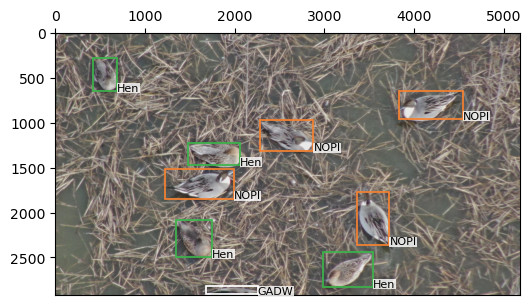

In [6]:
image_path = 'S:/Savanna Institute/Deep Learning/DuckNet/RetinaNet/filtered_images/DJI_20221216103105_0073_Z.JPG'
prediction = model.process_image(image_path)
print()
print(f"Prediction: {prediction}")
print()
image = model.load_image(image_path)
image = torchvision.transforms.functional.to_tensor(image)

plot_detections(image, prediction['boxes'], prediction['labels']) 

In [7]:
import os

# import datasets module from basemodel.pt.zip
file_path = 'basemodel.pt.zip'
module = 'datasets'

datasets = torch.package.PackageImporter(file_path).import_module(module)

def get_files(directory: str, extension: str):
    """
    Returns a sorted list of full file paths from a directory that match the given extension.
    Extension should include the dot (e.g. ".jpg", ".json").
    """
    return [os.path.join(directory, f) for f in sorted(os.listdir(directory))
            if f.lower().endswith(extension.lower())]

# Create sample dataset
jpg_dir = 'S:/Savanna Institute/Deep Learning/DuckNet/RetinaNet/filtered_images/'
json_dir = 'S:/Savanna Institute/Deep Learning/DuckNet/RetinaNet/filtered_annotations/'

jpgfiles = get_files(jpg_dir, '.jpg')
jsonfiles = get_files(json_dir, '.json')

sample_dataset = datasets.DetectionDataset(
    jpgfiles=jpgfiles,
    jsonfiles=jsonfiles,
    augment=True,
    negative_classes=[],
    class_list=model.class_list
)

image, target = sample_dataset[2]
print(image.shape)
print(target)

torch.Size([3, 810, 1440])
{'boxes': BoundingBoxes([[637.3777, 231.7815, 877.6181, 371.5484]], dtype=torch.float64, format=BoundingBoxFormat.XYXY, canvas_size=(810, 1440)), 'labels': tensor([5])}


In [8]:
sample_dataloader = datasets.create_dataloader(sample_dataset, batch_size = 8, shuffle = True)

In [9]:
images, targets = next(iter(sample_dataloader))
images = list(image for image in images)
targets = [{k: v for k, v in t.items()} for t in targets]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.212885..2.3088455].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.326275].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.0474079].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7030813..2.326275].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7925336..2.4482791].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.2739873].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.5280111..2.3

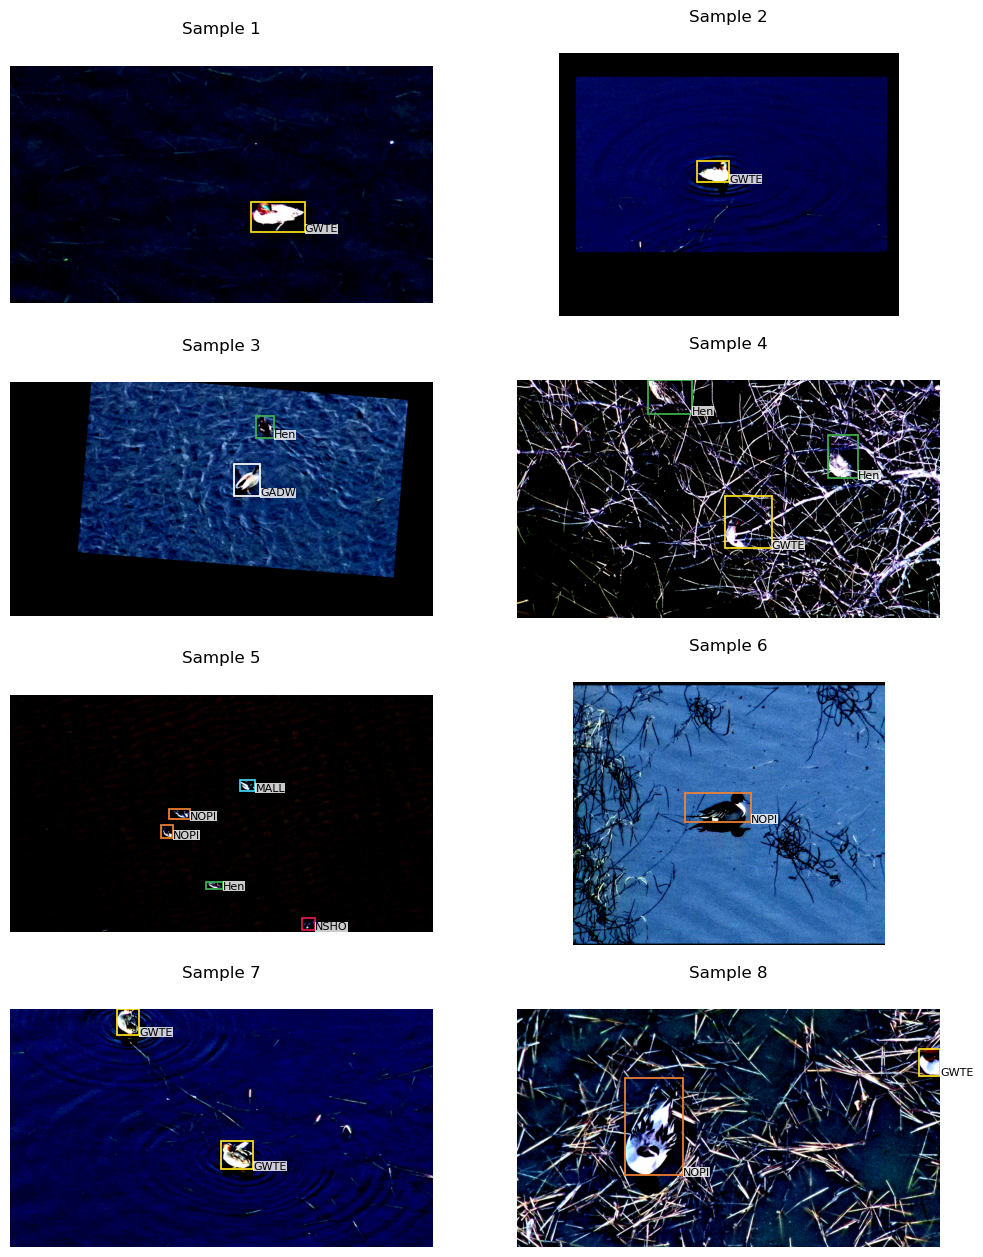

In [10]:
# Plot the all samples from batch in a grid of subplots. 
plt.figure(figsize = (12, 32))
for i in range(8):
    ax = plt.subplot(8, 2, 1 + i)
    plot_detections(images[i], targets[i]['boxes'], targets[i]['labels'], ax = ax)
    plt.axis('off')
    plt.title(f"Sample {i + 1}")

plt.show()

In [11]:
break

SyntaxError: 'break' outside loop (668683560.py, line 1)

### <center>Train model</center> 

In [12]:
model = load_model(file_path='basemodel.pt.zip', model_name='model')
imagefiles_train = get_files('S:/Savanna Institute/Deep Learning/DuckNet/RetinaNet/train/images/', '.jpg')
jsonfiles_train = get_files('S:/Savanna Institute/Deep Learning/DuckNet/RetinaNet/train/annotations/', '.json')
imagefiles_test = get_files('S:/Savanna Institute/Deep Learning/DuckNet/RetinaNet/test/images/', '.jpg')
jsonfiles_test = get_files('S:/Savanna Institute/Deep Learning/DuckNet/RetinaNet/test/annotations/', '.json')
model.start_training_detector(imagefiles_train = imagefiles_train,
                              jsonfiles_train = jsonfiles_train,
                              imagefiles_test = imagefiles_test,
                              jsonfiles_test = jsonfiles_test,
                              negative_classes = [],
                              epochs = 2,
                              lr = 0.001,
                              )

No new classes found. Using existing class list: ['AMCO', 'GADW', 'GWTE', 'Hen', 'MALL', 'NOPI', 'NSHO', 'REDH', 'RNDU']
DEBUG - Initial learning rate: 0.001
Epoch: [0] 1/571 classification: 0.0731 (0.0731)  bbox_regression: 0.0052 (0.0052)  loss: 0.0783 (0.0783)  lr: 0.0001 (0.0001)
Epoch: [0] 58/571 classification: 0.0687 (0.1093)  bbox_regression: 0.0104 (0.0154)  loss: 0.0777 (0.1247)  lr: 0.0002 (0.0001)
Epoch: [0] 115/571 classification: 0.0886 (0.1303)  bbox_regression: 0.0149 (0.0158)  loss: 0.1045 (0.1461)  lr: 0.0003 (0.0002)
Epoch: [0] 172/571 classification: 0.0738 (0.1224)  bbox_regression: 0.0112 (0.0153)  loss: 0.0862 (0.1377)  lr: 0.0004 (0.0002)
Epoch: [0] 229/571 classification: 0.0876 (0.1175)  bbox_regression: 0.0109 (0.0152)  loss: 0.1039 (0.1328)  lr: 0.0004 (0.0003)
Epoch: [0] 286/571 classification: 0.0798 (0.1115)  bbox_regression: 0.0131 (0.0148)  loss: 0.0917 (0.1263)  lr: 0.0005 (0.0003)
Epoch: [0] 343/571 classification: 0.0887 (0.1094)  bbox_regression: 0.

True

In [14]:
finetuned_model = DuckDetector(classes_of_interest=model.class_list)
finetuned_model.load_state_dict(model.state_dict())
finetuned_model.save('basemodel_finetuned.pt.zip')

'basemodel_finetuned.pt.zip'

### <center> Converting Darwin JSON to LabelMe JSON </center>

In [ ]:
# import json 

# def get_imagename_from_jsonfile(jsonfile):
#     with open(jsonfile, 'r') as j:
#         jsondata = json.loads(j.read())
#     return jsondata['item']['slots'][0]['source_files'][0]['file_name']


# def get_boxes_from_jsonfile(jsonfile):
#     '''Reads bounding boxes from a DARWIN json file and returns them as a (Nx4) array'''
#     with open(jsonfile, 'r') as j:
#         jsondata = json.loads(j.read())
        
#     boxes = []
#     for i in range(len(jsondata['annotations'])):
#         box = [[jsondata['annotations'][i]['bounding_box']['x'], # xmin
#                 jsondata['annotations'][i]['bounding_box']['y']], # ymin
#                 [jsondata['annotations'][i]['bounding_box']['x']+jsondata['annotations'][i]['bounding_box']['w'], # xmax
#                 jsondata['annotations'][i]['bounding_box']['y']+jsondata['annotations'][i]['bounding_box']['h']]] # ymax
#         boxes.append(box)
#     return boxes # return as (Nx4) array of bounding


# def get_labels_from_jsonfile(jsonfile):
#     '''Reads a list of labels in a DARWIN json file.'''
#     with open(jsonfile, 'r') as j:
#         jsondata = json.loads(j.read())
#     return [ a['name'] for a in jsondata['annotations'] ]
 

# def get_imagesize_from_jsonfile(jsonfile):
#     with open(jsonfile, 'r') as j:
#         jsondata = json.loads(j.read())
#     return (jsondata['item']['slots'][0]['height'], jsondata['item']['slots'][0]['width'])


# def darwin_to_labelme_json(jsondata):
#     # convert darwin json to labelme json format. 

#     # labelme json should have following format:
#     # {'version': '4.5.6',
#     #  'flags': {},
#     #  'shapes': [
#     #      {
#     #       'label': 'duck',
#     #       'points': [[xmin, ymin], [xmax, ymax]],
#     #       'group_id': null,
#     #       'shape_type': 'rectangle',
#     #       'flags': {}
#     #      },
#     #      ...
#     #  ],
#     # 'imagePath': 'path/to/image/file',
#     # 'imageData': 'base64 encoded image data',
#     # 'imageHeight': 480,
#     # 'imageWidth': 640}

#     # ignore the 'imageData' field. 

#     image_name = get_imagename_from_jsonfile(jsondata)
#     boxes = get_boxes_from_jsonfile(jsondata)
#     labels = get_labels_from_jsonfile(jsondata)
#     image_size = get_imagesize_from_jsonfile(jsondata)

#     shapes = []
#     for i in range(len(labels)):
#         shape = {'label': labels[i],
#                     'points': boxes[i],
#                     'group_id': 'null',
#                     'shape_type': 'rectangle',
#                     'flags': {}}
#         shapes.append(shape)

#     for i in range(len(labels)):
#         labelme_json = {'version': '4.5.6',
#                         'flags': {},
#                         'shapes': shapes,
#                         'imagePath': image_name,
#                         'imageData': '',
#                         'imageHeight': image_size[0],
#                         'imageWidth': image_size[1]}
#     return labelme_json

# jsonfile = "S:/Savanna Institute/Deep Learning/DuckNet/Annotations/DJI_20221221103938_0079_Z.json"
# labelme_json = darwin_to_labelme_json(jsonfile)


# with open('S:/Savanna Institute/Deep Learning/DuckNet/RetinaNet/filtered_annotations/DJI_20221221103938_0079_Z.json', 'w') as j:
#         json.dump(labelme_json, j)

# print(labelme_json)

In [ ]:
# import os

# dir = 'C:/Users/zack/Desktop/DuckNet_Data/'

# # create two new folders in dir: LabelMe_Annotations_Test and LabelMe_Annotations_Train
# os.makedirs(dir + 'LabelMe_Annotations_Test', exist_ok = True)
# os.makedirs(dir + 'LabelMe_Annotations_Train', exist_ok = True)

# # convert all json files in Annotations_Test to labelme json format and save them in LabelMe_Annotations_Test
# for jsonfile in os.listdir(dir + 'Annotations_Test/'):
#     labelme_json = darwin_to_labelme_json(dir + 'Annotations_Test/' + jsonfile)
#     with open(dir + 'LabelMe_Annotations_Test/' + jsonfile, 'w') as j:
#         json.dump(labelme_json, j)

# # convert all json files in Annotations_Train to labelme json format and save them in LabelMe_Annotations_Train
# for jsonfile in os.listdir(dir + 'Annotations_Train/'):
#     labelme_json = darwin_to_labelme_json(dir + 'Annotations_Train/' + jsonfile)
#     with open(dir + 'LabelMe_Annotations_Train/' + jsonfile, 'w') as j:
#         json.dump(labelme_json, j)